In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import root_mean_squared_error as rmse

# Load the data
train_data = pd.read_csv("tmp/filtered_data.csv")
test_data = pd.read_parquet("data/test_data.parquet")

# Convert expiry to datetime if it's not already
if train_data["expiry"].dtype != "datetime64[ns]":
    train_data["expiry"] = pd.to_datetime(train_data["expiry"])

# Get the target expiry date
target_date = pd.Timestamp("2025-05-08").date()


In [38]:
data_path = "data"
output_path = "output/"
temp_path = "tmp/"

sample_submission = pd.read_csv(f"{data_path}/sample_submission.csv")
submission_cols = sample_submission.columns.tolist()

In [39]:
# Filter rows with the specified expiry date
expiry_filter = train_data['expiry'].dt.date == target_date
target_rows = train_data[expiry_filter]

# Get indices of rows to be used for validation (50% of the rows with target expiry)
validation_indices = target_rows.sample(frac=0.5, random_state=43).index

# Create validation set
val_data = train_data.loc[validation_indices].copy()

# Remove validation data from training set
train_data = train_data.drop(validation_indices)

# Print shapes to confirm
print(f"Original training data shape: {len(train_data) + len(val_data)}")
print(f"New training data shape: {train_data.shape}")
print(f"Validation data shape: {val_data.shape}")
print(f"Test data shape: {test_data.shape}")

Original training data shape: 178340
New training data shape: (138752, 97)
Validation data shape: (39588, 97)
Test data shape: (12065, 96)


In [40]:
test_data.columns

Index(['timestamp', 'underlying', 'call_iv_24000', 'call_iv_24100',
       'call_iv_24200', 'call_iv_24300', 'call_iv_24400', 'call_iv_24500',
       'call_iv_24600', 'call_iv_24700', 'call_iv_24800', 'call_iv_24900',
       'call_iv_25000', 'call_iv_25100', 'call_iv_25200', 'call_iv_25300',
       'call_iv_25400', 'call_iv_25500', 'call_iv_25600', 'call_iv_25700',
       'call_iv_25800', 'call_iv_25900', 'call_iv_26000', 'call_iv_26100',
       'call_iv_26200', 'call_iv_26300', 'call_iv_26400', 'call_iv_26500',
       'put_iv_23000', 'put_iv_23100', 'put_iv_23200', 'put_iv_23300',
       'put_iv_23400', 'put_iv_23500', 'put_iv_23600', 'put_iv_23700',
       'put_iv_23800', 'put_iv_23900', 'put_iv_24000', 'put_iv_24100',
       'put_iv_24200', 'put_iv_24300', 'put_iv_24400', 'put_iv_24500',
       'put_iv_24600', 'put_iv_24700', 'put_iv_24800', 'put_iv_24900',
       'put_iv_25000', 'put_iv_25100', 'put_iv_25200', 'put_iv_25300',
       'put_iv_25400', 'put_iv_25500', 'X0', 'X1', 'X2',

In [41]:
train_data.columns

Index(['timestamp', 'underlying', 'expiry', 'call_iv_23500', 'call_iv_23600',
       'call_iv_23700', 'call_iv_23800', 'call_iv_23900', 'call_iv_24000',
       'call_iv_24100', 'call_iv_24200', 'call_iv_24300', 'call_iv_24400',
       'call_iv_24500', 'call_iv_24600', 'call_iv_24700', 'call_iv_24800',
       'call_iv_24900', 'call_iv_25000', 'call_iv_25100', 'call_iv_25200',
       'call_iv_25300', 'call_iv_25400', 'call_iv_25500', 'call_iv_25600',
       'call_iv_25700', 'call_iv_25800', 'call_iv_25900', 'call_iv_26000',
       'put_iv_22500', 'put_iv_22600', 'put_iv_22700', 'put_iv_22800',
       'put_iv_22900', 'put_iv_23000', 'put_iv_23100', 'put_iv_23200',
       'put_iv_23300', 'put_iv_23400', 'put_iv_23500', 'put_iv_23600',
       'put_iv_23700', 'put_iv_23800', 'put_iv_23900', 'put_iv_24000',
       'put_iv_24100', 'put_iv_24200', 'put_iv_24300', 'put_iv_24400',
       'put_iv_24500', 'put_iv_24600', 'put_iv_24700', 'put_iv_24800',
       'put_iv_24900', 'put_iv_25000', 'X0', '

In [42]:
pred_cols = list(
    filter(
        lambda x: x.startswith("call") or x.startswith("put"), val_data.columns.tolist()
    )
)
len(pred_cols)

52

## Setting 32 columns to nan randomly in each row

In [43]:
import os
if os.path.exists(f"{temp_path}/sample_val.csv") and os.path.exists(
    f"{temp_path}/val_Y.csv"
):
    # If the sample files already exist, load them
    sample_val = pd.read_csv(f"{temp_path}/sample_val.csv")
    val_Y = pd.read_csv(f"{temp_path}/val_Y.csv")
    print("Loaded existing sample_val and val_Y.")
else:
    # Create a copy of val_data to avoid modifying the original
    sample_val = val_data.copy()

    # Get the call and put columns separately
    call_cols = [col for col in pred_cols if col.startswith("call")]
    put_cols = [col for col in pred_cols if col.startswith("put")]

    # For each row, randomly select 16 call columns and 16 put columns to set to NaN
    for idx in sample_val.index:
        # Randomly select 16 call columns for this row
        nan_call_cols = np.random.choice(call_cols, size=16, replace=False)

        # Randomly select 16 put columns for this row
        nan_put_cols = np.random.choice(put_cols, size=16, replace=False)

        # Set these columns to NaN for this row
        sample_val.loc[idx, nan_call_cols] = np.nan
        sample_val.loc[idx, nan_put_cols] = np.nan

    # Create val_Y from the original validation data, containing only the target columns
    val_Y = val_data[pred_cols]
    sample_val.to_csv(f"{temp_path}/sample_val.csv", index=False)
    val_Y.to_csv(f"{temp_path}/val_Y.csv", index=False)

In [44]:
sample_val.shape

(39588, 97)

In [45]:
val_Y.shape

(39588, 52)

## Cubic Regression

In [46]:
# Extract strike prices from column names
call_strike_prices = np.array([float(col.split('_')[-1]) for col in pred_cols if col.startswith('call')])
put_strike_prices = np.array([float(col.split('_')[-1]) for col in pred_cols if col.startswith('put')])

# Initialize dataframe to store predictions
preds = pd.DataFrame(index=sample_val.index, columns=pred_cols)

# Function to perform quadratic regression for a single row
def quad_regression_predict(row, strike_prices, option_type):
    # Get column names for this option type
    cols = [col for col in pred_cols if col.startswith(option_type)]

    # Get non-NaN values and their corresponding strike prices
    valid_mask = ~row[cols].isna()
    valid_cols = np.array(cols)[valid_mask]

    if len(valid_cols) < 3:  # Need at least 3 points for quadratic regression
        return None

    y_vals = row[valid_cols].values.astype(np.float64)
    x_vals = np.array([float(col.split("_")[-1]) for col in valid_cols])
    # Perform quadratic regression
    coeffs = np.polyfit(x_vals, y_vals, 3)
    poly = np.poly1d(coeffs)

    # Predict for all strike prices of this option type
    all_strikes = strike_prices
    predictions = pd.Series(
        poly(all_strikes),
        index=[f"{option_type}_iv_{int(strike)}" for strike in all_strikes],
    )
    # predictions[valid_cols] = row[valid_cols].astype(np.float64)  # Keep original values for known strikes
    return predictions

# Apply regression for each row
for idx in sample_val.index:
  # Process call options
  call_predictions = quad_regression_predict(sample_val.loc[idx], call_strike_prices, 'call')
  if call_predictions is not None:
    preds.loc[idx, call_predictions.index] = call_predictions
  
  # Process put options
  put_predictions = quad_regression_predict(sample_val.loc[idx], put_strike_prices, 'put')
  if put_predictions is not None:
    preds.loc[idx, put_predictions.index] = put_predictions

# Fill in any missing values using original values (if any regression failed)
for col in pred_cols:
  nan_mask = preds[col].isna()
  if nan_mask.any():
    preds.loc[nan_mask, col] = sample_val.loc[nan_mask, col]

# Calculate RMSE between predictions and actual values
rmse_val = rmse(val_Y[pred_cols].values.flatten(), preds.values.flatten())
print(f"RMSE of quadratic regression prediction: {rmse_val}")

RMSE of quadratic regression prediction: 0.02180485798530697


In [47]:
[col for col in preds.columns if col not in pred_cols and col.startswith('call')]

[]

KeyError: 1000

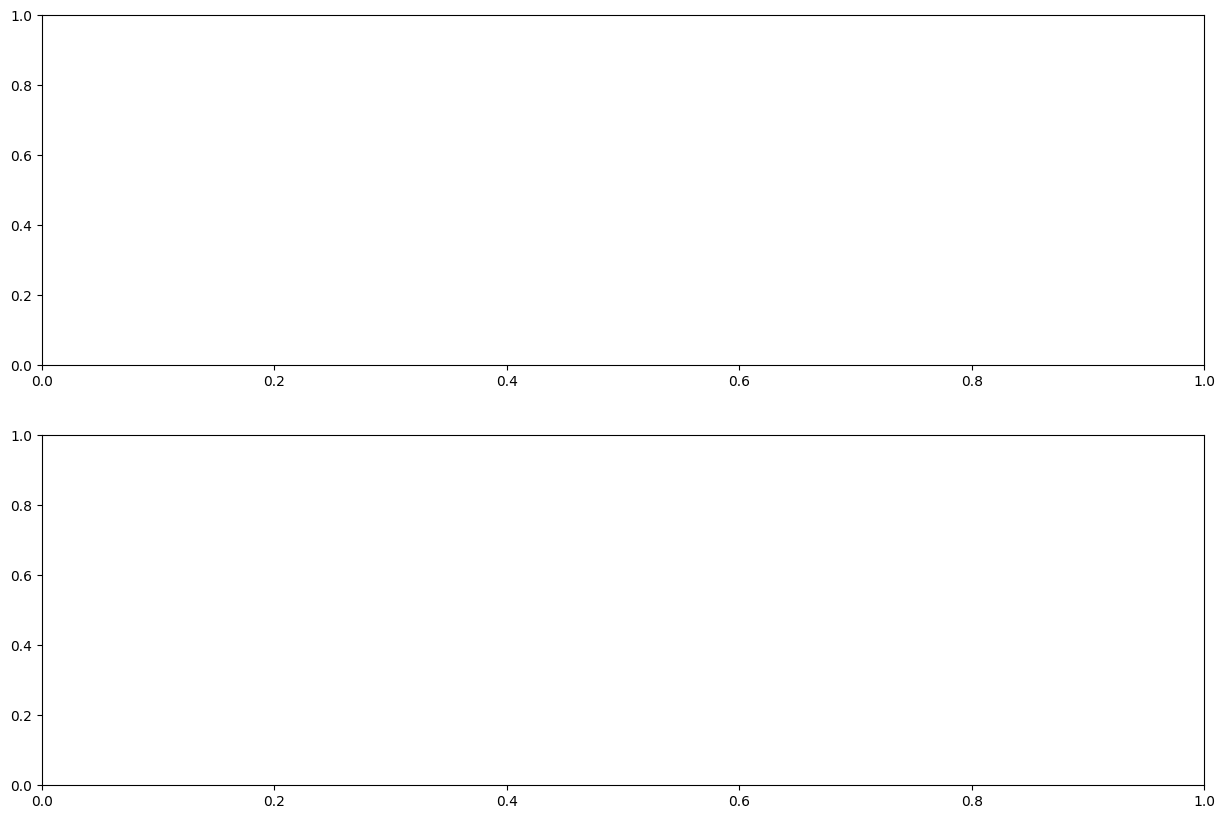

In [65]:
import seaborn as sns

# Create a visualization of val_Y vs preds for specific strikes
import matplotlib.pyplot as plt

# Select a few rows (timestamps) to visualize
sample_indices = [preds.index[1000]]

# Create a figure with subplots - one row for calls, one for puts
fig, axes = plt.subplots(2, 1, figsize=(15, 10))

# Define strike prices to use in plot
call_strikes = np.array(
    [float(col.split("_")[-1]) for col in pred_cols if col.startswith("call")]
)
put_strikes = np.array(
    [float(col.split("_")[-1]) for col in pred_cols if col.startswith("put")]
)

# Plot for each selected index
for idx in sample_indices:
    # Extract call option data
    call_cols = [col for col in pred_cols if col.startswith("call")]
    call_actual = val_Y.loc[idx , call_cols].values
    call_predicted = preds.loc[idx, call_cols].values
    call_sample = sample_val.loc[idx, call_cols].values

    # Plot call options
    axes[0].plot(call_strikes, call_actual, "o-", alpha=0.7, label=f"Actual {idx}")
    axes[0].plot(
        call_strikes, call_predicted, "x--", alpha=0.7, label=f"Predicted {idx}"
    )
    axes[0].plot(
        call_strikes, call_sample, "s:", alpha=0.7, label=f"Sample {idx}")

    # Extract put option data
    put_cols = [col for col in pred_cols if col.startswith("put")]
    put_actual = val_Y.loc[idx, put_cols].values
    put_predicted = preds.loc[idx, put_cols].values

    # Plot put options
    axes[1].plot(put_strikes, put_actual, "o-", alpha=0.7)
    axes[1].plot(put_strikes, put_predicted, "x--", alpha=0.7)

# Set titles and labels
axes[0].set_title("Call Option IV: Actual vs Predicted")
axes[0].set_xlabel("Strike Price")
axes[0].set_ylabel("Implied Volatility")
axes[0].grid(True)

axes[1].set_title("Put Option IV: Actual vs Predicted")
axes[1].set_xlabel("Strike Price")
axes[1].set_ylabel("Implied Volatility")
axes[1].grid(True)

# Add a legend to the first subplot only to avoid clutter
handles, labels = axes[0].get_legend_handles_labels()
legend_labels = [
    label.replace("Actual", "Actual Row").replace("Predicted", "Pred Row")
    for label in labels
]
axes[0].legend(handles, legend_labels, loc="upper left", bbox_to_anchor=(1.02, 1))

plt.tight_layout()
plt.show()

## Cubic: Saving Prediction on Test Data

In [58]:
test_pred_cols = list(
    filter(
        lambda x: x.startswith("call") or x.startswith("put"), test_data.columns.tolist()
    )
)

# Extract strike prices from column names
call_strike_prices = np.array(
    [float(col.split("_")[-1]) for col in test_pred_cols if col.startswith("call")]
)
put_strike_prices = np.array(
    [float(col.split("_")[-1]) for col in test_pred_cols if col.startswith("put")]
)

# Initialize dataframe to store predictions
preds = pd.DataFrame(index=test_data.index, columns=test_pred_cols)


# Function to perform quadratic regression for a single row
def quad_regression_predict(row, strike_prices, option_type):
    # Get column names for this option type
    cols = [col for col in test_pred_cols if col.startswith(option_type)]

    # Get non-NaN values and their corresponding strike prices
    valid_mask = ~row[cols].isna()
    valid_cols = np.array(cols)[valid_mask]

    if len(valid_cols) < 4:  # Need at least 3 points for quadratic regression
        print("<4 valid cols for", option_type, "at row", row.name)
        return None

    y_vals = row[valid_cols].values.astype(np.float64)
    x_vals = np.array([float(col.split("_")[-1]) for col in valid_cols])
    # Perform quadratic regression
    coeffs = np.polyfit(x_vals, y_vals, 3)
    poly = np.poly1d(coeffs)

    # Predict for all strike prices of this option type
    all_strikes = strike_prices
    predictions = pd.Series(
        poly(all_strikes),
        index=[f"{option_type}_iv_{int(strike)}" for strike in all_strikes],
    )
    predictions[valid_cols] = row[valid_cols].astype(
        np.float64
    )  # Keep original values for known strikes
    return predictions


# Apply regression for each row
for idx in test_data.index:
    # Process call options
    call_predictions = quad_regression_predict(
        test_data.loc[idx], call_strike_prices, "call"
    )
    if call_predictions is not None:
        preds.loc[idx, call_predictions.index] = call_predictions

    # Process put options
    put_predictions = quad_regression_predict(
        test_data.loc[idx], put_strike_prices, "put"
    )
    if put_predictions is not None:
        preds.loc[idx, put_predictions.index] = put_predictions

# Fill in any missing values using original values (if any regression failed)
for col in test_pred_cols:
    nan_mask = preds[col].isna()
    if nan_mask.any():
        preds.loc[nan_mask, col] = test_data.loc[nan_mask, col]
test_data[preds.columns] = preds
test_data

,timestamp,underlying,call_iv_24000,call_iv_24100,call_iv_24200,call_iv_24300,call_iv_24400,call_iv_24500,call_iv_24600,call_iv_24700,...,X32,X33,X34,X35,X36,X37,X38,X39,X40,X41
0,0,24735.9,0.280939,0.267866,0.255394,0.245351,0.242149,0.232242,0.232439,0.22793,...,0.006587,0.002826,-1.737617e+05,-0.009541,-0.017831,0.000264,2.032521e+06,1.000000e-06,-0.077238,-5.362742e+06
1,1,24766.7,0.270276,0.262457,0.258893,0.245408,0.239628,0.235622,0.233548,0.232763,...,0.005777,0.004588,-3.195086e+05,-0.024106,-0.004696,-0.000158,-4.529075e+06,-1.619022e+06,-0.956928,4.624907e+06
2,2,24896.9,0.273826,0.251731,0.237522,0.22318,0.214869,0.20458,0.194604,0.188842,...,0.000829,-0.034944,1.027525e+06,0.028201,0.032234,0.007687,2.663908e+06,0.000000e+00,-0.116264,-2.669766e+06
3,3,24898.1,0.241888,0.229621,0.220505,0.20496,0.198602,0.18619,0.183141,0.179613,...,-0.009323,-0.022969,-4.720074e+06,-0.001513,0.008704,-0.000206,-7.672936e+06,-1.903406e+06,-2.249208,-1.858254e+07
4,4,24906.5,0.235328,0.229039,0.222983,0.214126,0.203866,0.197368,0.192603,0.187277,...,-0.018674,-0.007588,-4.051681e+05,-0.136267,0.002425,-0.002200,1.334469e+06,2.548789e+05,1.999104,3.024212e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12060,12060,24992.1,0.245645,0.233427,0.222685,0.212967,0.204402,0.196975,0.19067,0.186856,...,-0.010750,0.006911,-1.497117e+05,-0.059785,-0.014518,-0.006756,-7.822864e+06,2.149933e+05,-2.069687,-6.738094e+06
12061,12061,25020.3,0.250477,0.23638,0.226972,0.215943,0.207181,0.200906,0.193655,0.188452,...,-0.000224,0.024468,-1.176289e+06,-0.016344,-0.034368,0.001133,-2.392407e+06,-1.176289e+06,-2.023157,6.031379e+03
12062,12062,24897.2,0.256475,0.243817,0.234267,0.22127,0.204786,0.196138,0.18958,0.185088,...,-0.009009,0.006057,1.920387e+06,-0.016521,-0.013230,-0.009278,2.287786e+06,0.000000e+00,1.751653,-3.621450e+06
12063,12063,25035.6,0.252901,0.239825,0.228602,0.21838,0.209397,0.20162,0.195014,0.190833,...,0.001625,0.063421,6.357844e+05,0.077753,0.068983,0.000112,8.723009e+06,2.352188e+05,1.502687,-1.177899e+06


In [59]:
test_data[test_pred_cols].isna().sum().sum()

0

In [60]:
# filling remaining 122 nan values (< 3 valid cols)
for col in test_pred_cols:
    test_df_col = test_data[col].copy()
    test_df_col.dropna(inplace=True)
    median = test_df_col.median()
    # print(median)
    test_data[col] = test_data[col].fillna(median)

C:\Users\Hp\AppData\Local\Temp\ipykernel_24516\248187873.py:7: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  test_data[col] = test_data[col].fillna(median)
C:\Users\Hp\AppData\Local\Temp\ipykernel_24516\248187873.py:7: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  test_data[col] = test_data[col].fillna(median)
C:\Users\Hp\AppData\Local\Temp\ipykernel_24516\248187873.py:7: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to 

In [61]:
preds

,call_iv_24000,call_iv_24100,call_iv_24200,call_iv_24300,call_iv_24400,call_iv_24500,call_iv_24600,call_iv_24700,call_iv_24800,call_iv_24900,...,put_iv_24600,put_iv_24700,put_iv_24800,put_iv_24900,put_iv_25000,put_iv_25100,put_iv_25200,put_iv_25300,put_iv_25400,put_iv_25500
0,0.280939,0.267866,0.255394,0.245351,0.242149,0.232242,0.232439,0.22793,0.222997,0.227966,...,0.232334,0.228923,0.228773,0.227301,0.234169,0.239945,0.250422,0.257362,0.269147,0.282229
1,0.270276,0.262457,0.258893,0.245408,0.239628,0.235622,0.233548,0.232763,0.233827,0.229917,...,0.23293,0.228209,0.231456,0.234437,0.240069,0.249402,0.259805,0.274169,0.291704,0.312539
2,0.273826,0.251731,0.237522,0.22318,0.214869,0.20458,0.194604,0.188842,0.185508,0.180668,...,0.194612,0.188052,0.186468,0.183883,0.181346,0.184554,0.19075,0.194004,0.202393,0.213422
3,0.241888,0.229621,0.220505,0.20496,0.198602,0.18619,0.183141,0.179613,0.177834,0.177728,...,0.176274,0.166394,0.161561,0.165479,0.165963,0.172032,0.173964,0.181784,0.192354,0.206107
4,0.235328,0.229039,0.222983,0.214126,0.203866,0.197368,0.192603,0.187277,0.183704,0.181128,...,0.19256,0.187086,0.182584,0.17792,0.176926,0.176,0.176442,0.178407,0.182314,0.187286
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12060,0.245645,0.233427,0.222685,0.212967,0.204402,0.196975,0.19067,0.186856,0.181359,0.178101,...,0.193297,0.187128,0.182097,0.17727,0.175894,0.174942,0.176356,0.177716,0.181995,0.188015
12061,0.250477,0.23638,0.226972,0.215943,0.207181,0.200906,0.193655,0.188452,0.184561,0.181763,...,0.210263,0.195313,0.185634,0.180196,0.177969,0.177923,0.179028,0.180254,0.180571,0.178949
12062,0.256475,0.243817,0.234267,0.22127,0.204786,0.196138,0.18958,0.185088,0.17976,0.177229,...,0.192306,0.185897,0.179666,0.176916,0.177095,0.178562,0.182547,0.189238,0.20136,0.20994
12063,0.252901,0.239825,0.228602,0.21838,0.209397,0.20162,0.195014,0.190833,0.185851,0.18156,...,0.198805,0.190933,0.186172,0.18211,0.178973,0.177231,0.176993,0.178806,0.181466,0.186395


In [62]:
print(test_data.isna().sum().sum())
quad_submission = test_data[submission_cols]
quad_submission.to_csv(f"{output_path}/cube_poly_submission.csv", index=False)
quad_submission

0


,timestamp,call_iv_24000,call_iv_24100,call_iv_24200,call_iv_24300,call_iv_24400,call_iv_24500,call_iv_24600,call_iv_24700,call_iv_24800,...,put_iv_24600,put_iv_24700,put_iv_24800,put_iv_24900,put_iv_25000,put_iv_25100,put_iv_25200,put_iv_25300,put_iv_25400,put_iv_25500
0,0,0.280939,0.267866,0.255394,0.245351,0.242149,0.232242,0.232439,0.227930,0.222997,...,0.232334,0.228923,0.228773,0.227301,0.234169,0.239945,0.250422,0.257362,0.269147,0.282229
1,1,0.270276,0.262457,0.258893,0.245408,0.239628,0.235622,0.233548,0.232763,0.233827,...,0.232930,0.228209,0.231456,0.234437,0.240069,0.249402,0.259805,0.274169,0.291704,0.312539
2,2,0.273826,0.251731,0.237522,0.223180,0.214869,0.204580,0.194604,0.188842,0.185508,...,0.194612,0.188052,0.186468,0.183883,0.181346,0.184554,0.190750,0.194004,0.202393,0.213422
3,3,0.241888,0.229621,0.220505,0.204960,0.198602,0.186190,0.183141,0.179613,0.177834,...,0.176274,0.166394,0.161561,0.165479,0.165963,0.172032,0.173964,0.181784,0.192354,0.206107
4,4,0.235328,0.229039,0.222983,0.214126,0.203866,0.197368,0.192603,0.187277,0.183704,...,0.192560,0.187086,0.182584,0.177920,0.176926,0.176000,0.176442,0.178407,0.182314,0.187286
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12060,12060,0.245645,0.233427,0.222685,0.212967,0.204402,0.196975,0.190670,0.186856,0.181359,...,0.193297,0.187128,0.182097,0.177270,0.175894,0.174942,0.176356,0.177716,0.181995,0.188015
12061,12061,0.250477,0.236380,0.226972,0.215943,0.207181,0.200906,0.193655,0.188452,0.184561,...,0.210263,0.195313,0.185634,0.180196,0.177969,0.177923,0.179028,0.180254,0.180571,0.178949
12062,12062,0.256475,0.243817,0.234267,0.221270,0.204786,0.196138,0.189580,0.185088,0.179760,...,0.192306,0.185897,0.179666,0.176916,0.177095,0.178562,0.182547,0.189238,0.201360,0.209940
12063,12063,0.252901,0.239825,0.228602,0.218380,0.209397,0.201620,0.195014,0.190833,0.185851,...,0.198805,0.190933,0.186172,0.182110,0.178973,0.177231,0.176993,0.178806,0.181466,0.186395


### TODO: READ TEST DATA AGAIN

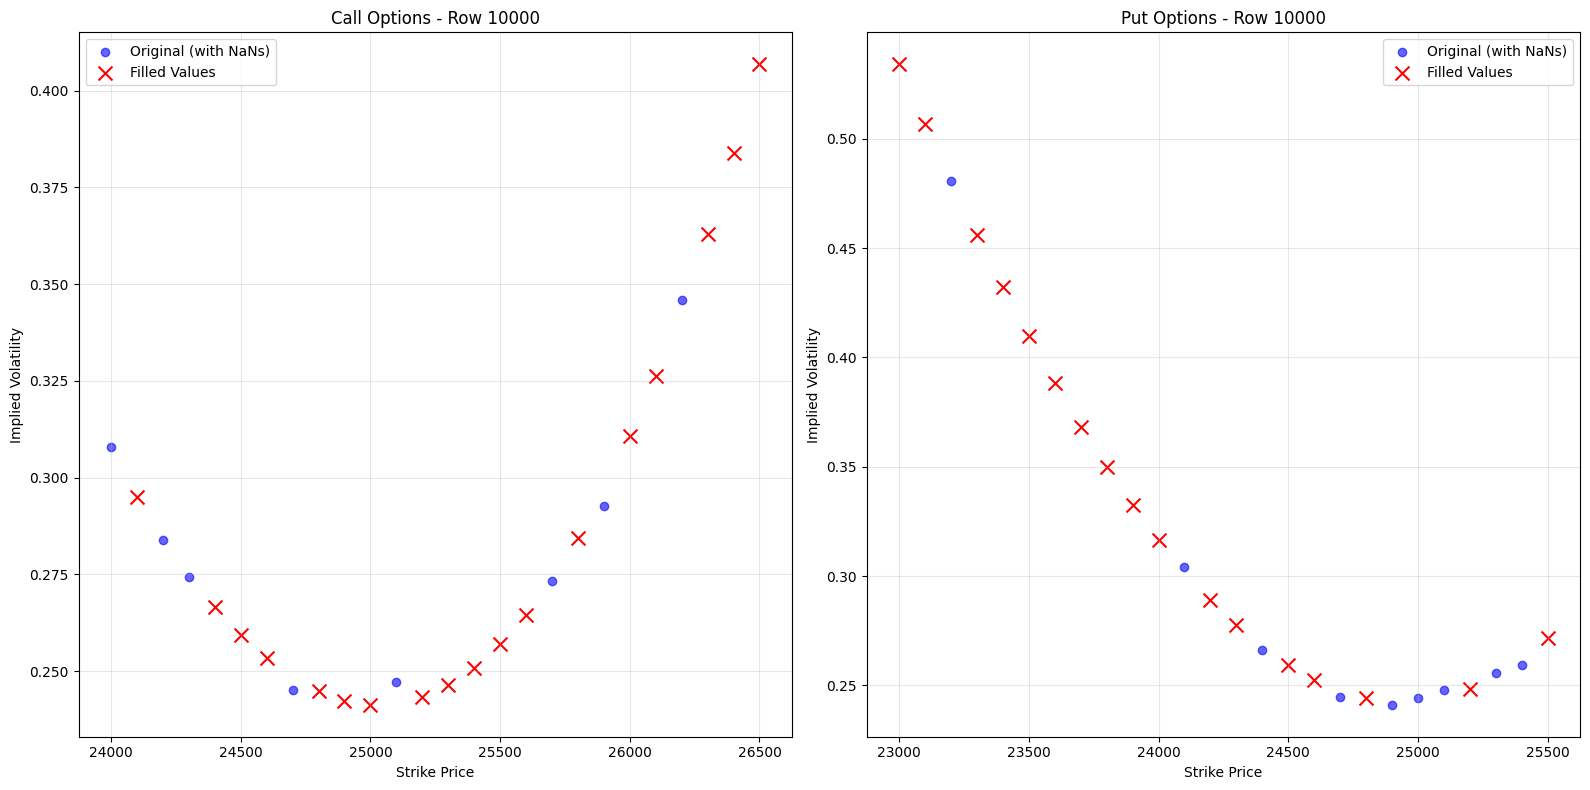

In [71]:
# Load test data into another variable for comparison
original_test_data = pd.read_parquet("data/test_data.parquet")


def compare_predictions(row_idx, data_type=["call", "put"]):
    """
    Draw a graph comparing original test data with filled data for a specific row

    Parameters:
    row_idx (int): The index of the row to plot
    data_type (list): Types of options to plot - "call", "put", or both
    """
    plt.figure(figsize=(16, 8))

    if "call" in data_type:
        call_cols = [col for col in test_pred_cols if col.startswith("call")]
        call_strikes = np.array([float(col.split("_")[-1]) for col in call_cols])

        plt.subplot(1, 2, 1)
        # Original data with NaNs
        plt.scatter(
            call_strikes,
            original_test_data.loc[row_idx, call_cols],
            color="blue",
            label="Original (with NaNs)",
            alpha=0.6,
        )

        # Plot NaN points differently
        nan_mask = original_test_data.loc[row_idx, call_cols].isna()
        plt.scatter(
            call_strikes[nan_mask],
            test_data.loc[row_idx, call_cols].values[nan_mask],
            color="red",
            marker="x",
            s=100,
            label="Filled Values",
        )

        plt.title("Call Options - Row {}".format(row_idx))
        plt.xlabel("Strike Price")
        plt.ylabel("Implied Volatility")
        plt.legend()
        plt.grid(True, alpha=0.3)

    if "put" in data_type:
        put_cols = [col for col in test_pred_cols if col.startswith("put")]
        put_strikes = np.array([float(col.split("_")[-1]) for col in put_cols])

        plt.subplot(1, 2, 2)
        # Original data with NaNs
        plt.scatter(
            put_strikes,
            original_test_data.loc[row_idx, put_cols],
            color="blue",
            label="Original (with NaNs)",
            alpha=0.6,
        )

        # Plot NaN points differently
        nan_mask = original_test_data.loc[row_idx, put_cols].isna()
        plt.scatter(
            put_strikes[nan_mask],
            test_data.loc[row_idx, put_cols].values[nan_mask],
            color="red",
            marker="x",
            s=100,
            label="Filled Values",
        )

        plt.title("Put Options - Row {}".format(row_idx))
        plt.xlabel("Strike Price")
        plt.ylabel("Implied Volatility")
        plt.legend()
        plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()


# Find a row with some NaN values to demonstrate

compare_predictions(10000)